# Выбор локации для скважины

Добывающей компании нужно помочь с выбором бурения новой скважины.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также нужно проанализировать возможную прибыль и риски.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv`.


`id` — уникальный идентификатор скважины;

`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

`product` — объём запасов в скважине (тыс. баррелей).

<a id='section_1'></a>
**Условия задачи:**

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

* Бюджет на разработку скважин в регионе — 10 млрд рублей.

* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
# основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# методы для обучения моделей
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

Сохраним переменные из [условий задачи](#section_1).

In [2]:
# константы
POINTS = 500
BEST_POINTS = 200
BUDGET = 10e9
PROFIT_PER_UNIT = 450e3
LOSSES_PROBABILITY = .025

TEST_SIZE = .25
RANDOM_STATE = 42

# параметры вывода графиков
plt.rcParams['figure.titlesize'] = 17
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['font.size'] = 13

Объявим функции, которые понадобятся в ходе решения, в начале проекта.

In [3]:
def data_import(file_name: str) -> pd.DataFrame:

    local_pth = '/datasets/' + file_name
    server_pth = 'https://example.ru/' + file_name

    try:
        data = pd.read_csv(local_pth, index_col='id')
    except:
        data = pd.read_csv(server_pth,  index_col='id')
    
    data.sort_index(inplace=True)
    
    return data

In [4]:
def data_split(df):
    
    '''
    Function uses "train_test_split" for preparing train and test data.
    
    Input
    -------
    df: pd.DataFrame, drop_column: str
    
    Return
    -------
    X_train, X_test, y_train, y_test
    '''
    
    X_train, X_test, y_train, y_test =  train_test_split(
        df.drop('product', axis=1),
        df['product'],
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE)
    
    print(f'train_shape - {X_train.shape}\ntest_shape - {X_test.shape}\n')
    
    return X_train, X_test, y_train, y_test

In [5]:
def minmax_scaler(train, test, FEATURE_RANGE=(0, 1)):
    
    '''
    Function uses "MinMaxScaler" for scaling numeric data.
    
    Input
    -------
    train, test: pd.DataFrame

    Return
    -------
    Scaled train, test.
    '''
    
    scaler = MinMaxScaler(feature_range=FEATURE_RANGE)
    scaler.fit(pd.DataFrame(train))
    names_out = scaler.get_feature_names_out()
    
    train = pd.DataFrame(scaler.transform(pd.DataFrame(train)), index=train.index, columns=names_out)
    test = pd.DataFrame(scaler.transform(pd.DataFrame(test)), index=test.index, columns=names_out)
    
    return train, test

In [6]:
def l_reg_model(X_train, X_test, y_train, y_test):
    
    '''
    Function uses "LinearRegression". 
    
    Input
    -------
    X_train, X_test, y_train, y_test, y_scaler
    
    Return
    -------
    Fitted model, predicted target
    '''
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_preds = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=['product'])
    print(f'Cр.запас сырья (предсказанный), тыс.барр.: {y_preds["product"].mean():.2f}')
    
    score = root_mean_squared_error(y_test, y_preds)
    print(f'Метрика RMSE, тыс.барр: {score:.2f}')
    
    return model, y_preds["product"]

In [7]:
def profits_and_risks(target, target_pred):
    
    '''
    '''
    STATE = np.random.RandomState(12345)  
    
    data = pd.concat([target, target_pred], axis=1)
    data.columns = ['target', 'target_pred']
    
    profits = []
    
    for i in range(1000):
        data_subsample = data.sample(frac=(POINTS/len(target_pred)), replace=True, random_state=STATE)
        target_subsample = data_subsample['target']
        target_pred_subsample = data_subsample['target_pred']
        
        profits.append(calculate_profit(target_subsample, target_pred_subsample))
    
    profits = pd.Series(profits, name='profit')

    
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    
    risks = (profits < 0).sum() / len(profits)
    
    if risks < LOSSES_PROBABILITY:
        print(f"Средняя прибыль, млрд.руб.: {profits.mean():.3f}\n")
        print("Доверительный интервал 95%\n-------------------------")
        print(f"Нижняя граница, млрд.руб.: {lower:.3f}")
        print(f"Верхняя граница, млрд.руб.: {upper:.3f}\n")
        print(f"Риск убытков: {risks:.2%}")
        print()
        
    else:
        print(f"Риск убытков: {risks:.2%}")
    
    return profits

In [8]:
def calculate_profit(target: pd.Series, target_pred: pd.Series, count:int = BEST_POINTS) -> float:
    
    data = pd.concat([target, target_pred], axis=1)
    data.columns = ['target', 'target_pred']
    data = data.sort_values(by='target_pred', ascending=False)
    
    selected = data['target'][:200]
    selected_sum = selected.sum()
    
    total_profit = (PROFIT_PER_UNIT * selected_sum - BUDGET)/ 1e9
    
    return total_profit

### Загрузка данных

In [9]:
# загрузим данные
geo_data_0 = data_import('geo_data_0.csv')
geo_data_1 = data_import('geo_data_1.csv')
geo_data_2 = data_import('geo_data_2.csv')

In [10]:
# выведем первые строки таблиц
for i, df in enumerate([geo_data_0, geo_data_1, geo_data_2]):
    print("=" * 15, f'geo_{str(i)}', "=" * 15)
    display(df.head())
    print()

=============== geo_0 ===============


,f0,f1,f2,product
id,,,,
006OJ,1.289189,-0.623324,3.642039,142.822141
009eY,1.958091,0.268711,3.702938,112.036815
00AfQ,0.558807,-0.366895,-1.268154,49.659570
00AuZ,-0.968699,0.416057,3.553416,73.351787
00BTM,-0.908137,0.036964,1.053951,38.664619



=============== geo_1 ===============


,f0,f1,f2,product
id,,,,
0022J,-1.757135,-8.432343,1.999313,53.906522
003Gl,2.862304,-2.622592,1.999858,57.085625
003Vx,3.480454,-16.404208,3.000960,80.859783
004LG,5.632612,5.149203,3.004665,80.859783
006oG,-4.954731,-11.776300,5.001760,137.945408



=============== geo_2 ===============


,f0,f1,f2,product
id,,,,
009Gl,0.557780,-1.771009,4.646146,130.621072
00AuD,0.896418,0.296979,6.032145,112.891391
00CaL,-1.022474,-0.744512,4.243409,132.792852
00Cby,-1.183997,2.327663,2.691216,97.174303
00NQN,-1.476102,0.455868,2.025839,85.888480


In [11]:
# выведем сводную информацию о датафреймах
for i, df in enumerate([geo_data_0, geo_data_1, geo_data_2]):
    print("=" * 15, f'geo_{str(i)}', "=" * 15)
    print(df.info(), '\n')

=============== geo_0 ===============
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 006OJ to zzzLH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None 

=============== geo_1 ===============
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0022J to zzzvI
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None 

=============== geo_2 ===============
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 009Gl to zzz9h
Data columns (total 4 columns)

Данные трех регионов были загружены. В кажом датафрейме данные о 10 тысячах скважин.

Все данные числовые, в данных не наблюдается пропусков, данные верно типизированы.

### Предобработка данных

In [12]:
# выведем количество дублирующихся строк с данными
for i, df in enumerate([geo_data_0, geo_data_1, geo_data_2]):
    print("=" * 15, f'geo_{str(i)}', "=" * 15)
#     print(f'Кол-во дублирующихся индексов: {df.index.duplicated().sum()}')
    print(f'Кол-во дубликатов: {df.duplicated().sum()}')
    print(f'Кол-во дубликатов входных признаков: {df[["f0","f1","f2"]].duplicated().sum()}\n')

=============== geo_0 ===============
Кол-во дубликатов: 0
Кол-во дубликатов входных признаков: 0

=============== geo_1 ===============
Кол-во дубликатов: 0
Кол-во дубликатов входных признаков: 0

=============== geo_2 ===============
Кол-во дубликатов: 0
Кол-во дубликатов входных признаков: 0



Дублирующихся данных не наблюдается. Данные входных признаков уникальны.

### Исследовательский анализ данных

In [13]:
# выведем статистику числовых данных (все данные) по таблицам
for i, df in enumerate([geo_data_0, geo_data_1, geo_data_2]):
    print("=" * 15, f'geo_{str(i)}', "=" * 15)
    display(df.describe())
    print()

=============== geo_0 ===============


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



=============== geo_1 ===============


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



=============== geo_2 ===============


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


В данных не наблюдается выбросов.

Данные во всех колонках распределены в разном интервале. Для наглядности построим гистограммы распределения.

У целевого признака достаточно большая дисперсия ~2000 (44.8^2).

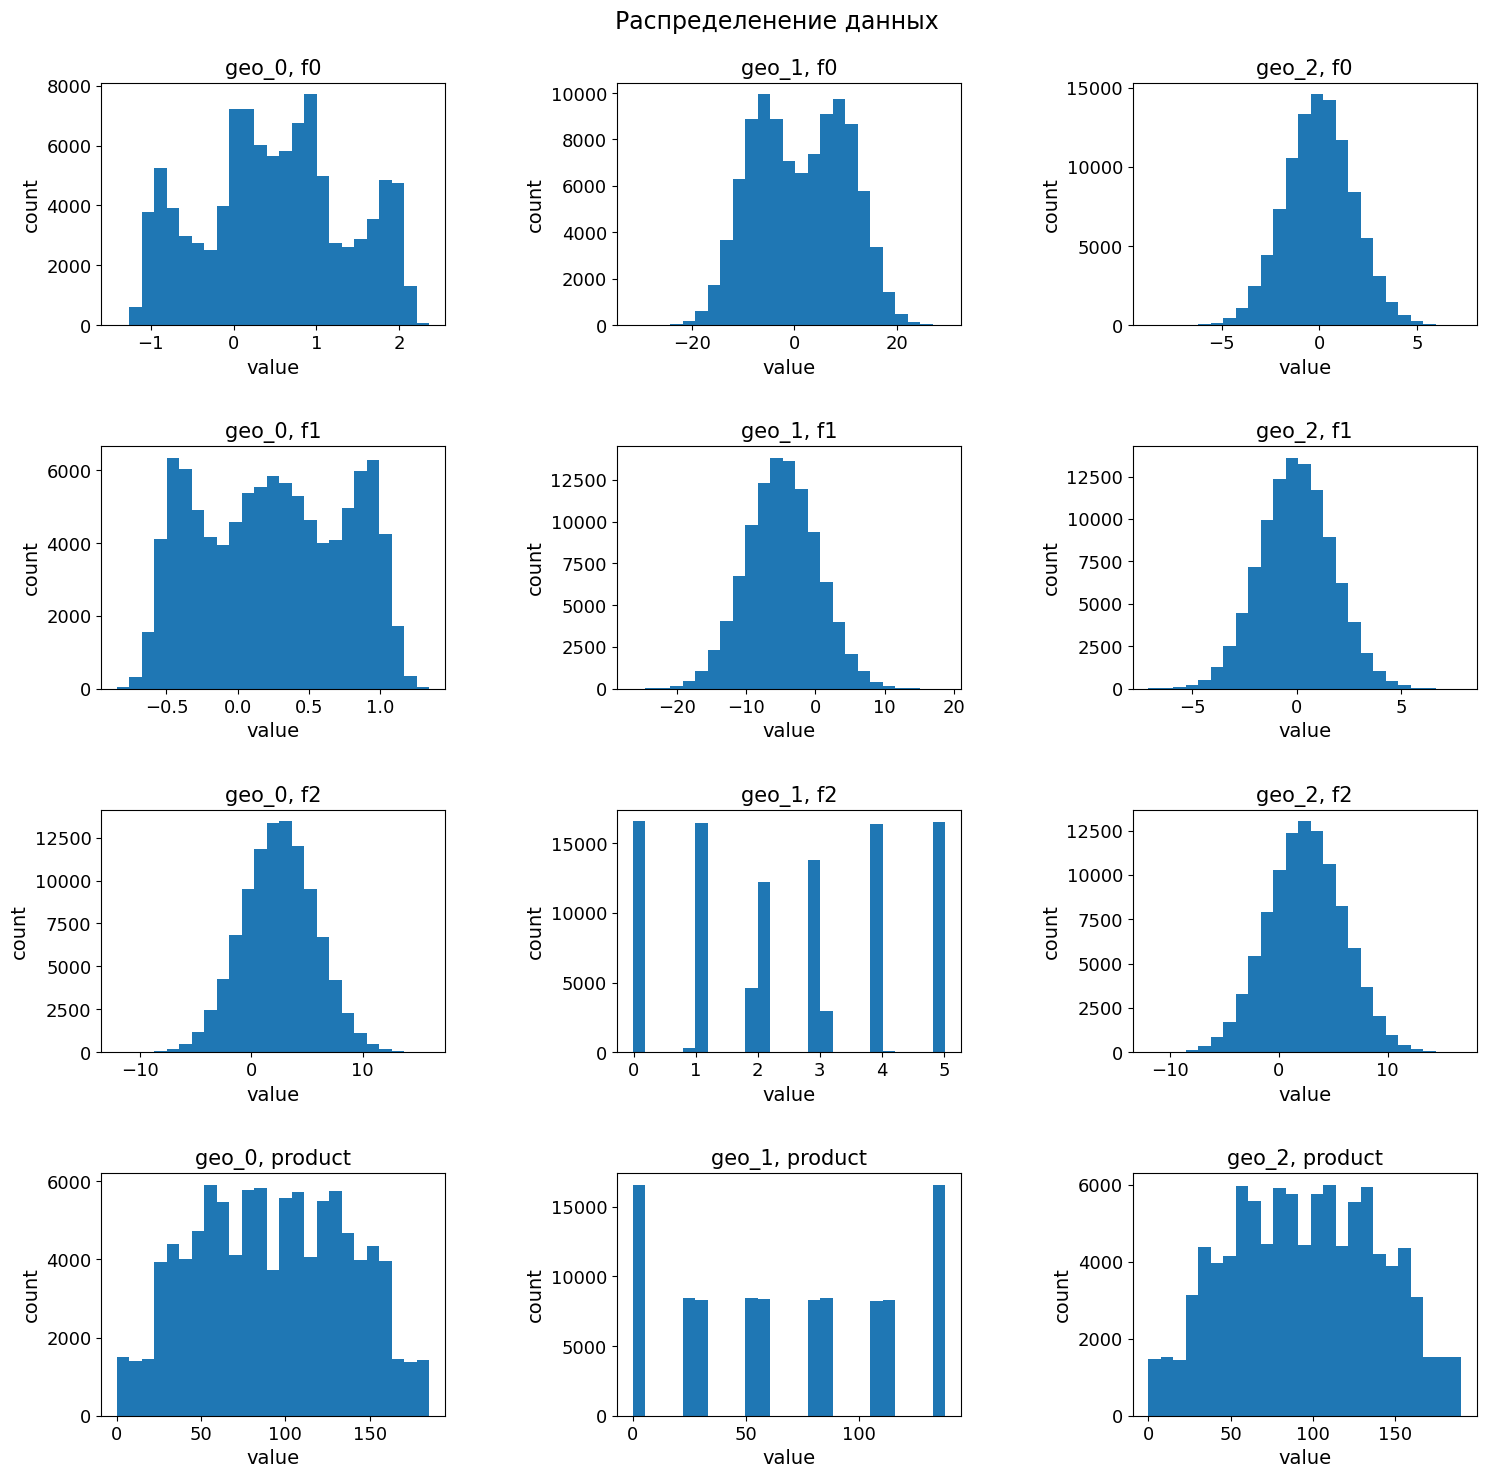

In [14]:
# построим графики распределения данных 
fig, ax = plt.subplots(4,3, figsize=(15,15))
fig.suptitle('Распределенение данных')
fig.tight_layout(pad=2)
plt.subplots_adjust(wspace=.5, hspace=0.5)
for i, df in enumerate([geo_data_0, geo_data_1, geo_data_2]):
    for j, col in enumerate(df.columns):
        ax[j,i].hist(df[col], bins=25)
        ax[j,i].set_title(f'geo_{str(i)}, {col}')
        ax[j,i].set_ylabel('count')
        ax[j,i].set_xlabel('value')

Для более корректой работы с моделью линейной регрессии следует масштабировать все данные.

С целю сохранения исходного вида распределения данных входные признаки следует масштабировать в интервале `(-1,1)`, а целевой — в интервале `(0,1)`.

### Корреляционный анализ данных

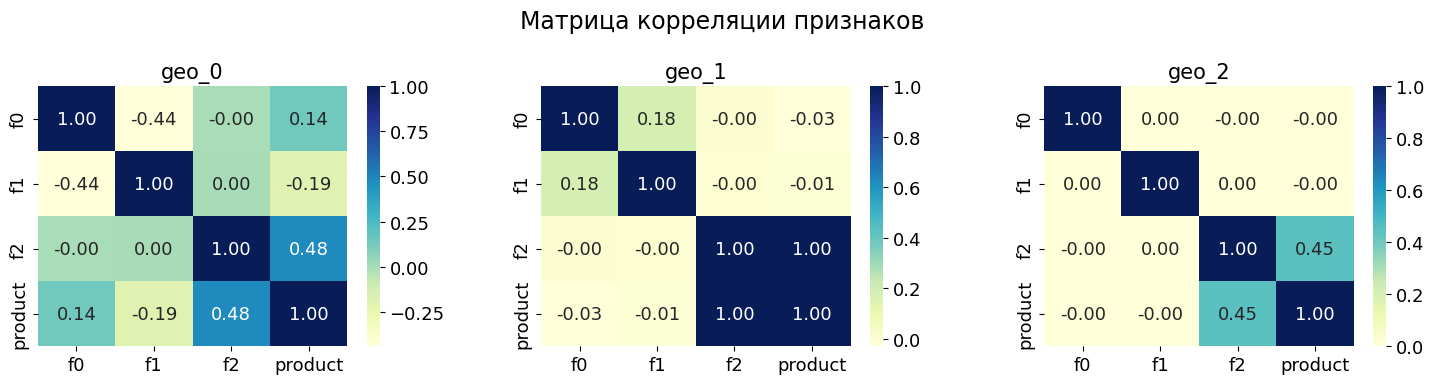

In [15]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
fig.suptitle('Матрица корреляции признаков')
fig.tight_layout(pad=1.5)
plt.subplots_adjust(wspace=.3)

for i, df in enumerate([geo_data_0, geo_data_1, geo_data_2]):
    corr_m = df.corr()
    sns.heatmap(corr_m, annot=True, cmap='YlGnBu', fmt=".2f", ax=ax[i])
    ax[i].set_title(f'geo_{str(i)}')


Мультиколлинеарности между входными признаками для всех регионов не наблюдается, тогда как для второго региона между признаком `f2` и целевым наблюдается коэфф. корреляции равный `1`, что может свидетельствовать об утечке данных.

Так как все входные признаки одинаково значимы, сохраним данный признак.

### Выводы

1. Данные были очищены от дублирующихся значений `id`.


2. Все количественные данные необходимо масштабировать для корректного обучения модели, так как данные имеют разный разброс, из-за чего модель может увеличить значимость признаков.


3. Для второго региона наблюдается сильная корреляция между входным признаком `f2` и целевым, так как все входные признаки значимы, данные сохранены.

## Обучение и проверка модели

### Разделение данных на выборки

In [16]:
# разделим данные на тренировочную и тестовую выборку
print(f'{"geo_0":=^30}')
X_train_0, X_test_0, y_train_0, y_test_0 = data_split(geo_data_0)
print(f'{"geo_1":=^30}')
X_train_1, X_test_1, y_train_1, y_test_1 = data_split(geo_data_1)
print(f'{"geo_2":=^30}')
X_train_2, X_test_2, y_train_2, y_test_2 = data_split(geo_data_2)

============geo_0=============
train_shape - (75000, 3)
test_shape - (25000, 3)

============geo_1=============
train_shape - (75000, 3)
test_shape - (25000, 3)

============geo_2=============
train_shape - (75000, 3)
test_shape - (25000, 3)



Данные корректно разделены.

### Масштабирование данных

In [17]:
# масштабируем входные признаки
X_train_scaled_0, X_test_scaled_0 = minmax_scaler(X_train_0, X_test_0, (-1,1))
X_train_scaled_1, X_test_scaled_1 = minmax_scaler(X_train_1, X_test_1, (-1,1))
X_train_scaled_2, X_test_scaled_2 = minmax_scaler(X_train_2, X_test_2, (-1,1))

Данные масштабированы перед обучением моделей.

### Обучение моделей

In [18]:
# обучим модели и сохраним предсказанные значения
print(f'{"geo_0":=^30}')
model_0, y_preds_0 = l_reg_model(X_train_scaled_0, X_test_scaled_0, y_train_0, y_test_0)
print()

print(f'{"geo_1":=^30}')
model_1, y_preds_1 = l_reg_model(X_train_scaled_1, X_test_scaled_1, y_train_1, y_test_1)
print()

print(f'{"geo_2":=^30}')
model_2, y_preds_2 = l_reg_model(X_train_scaled_2, X_test_scaled_2, y_train_2, y_test_2)

============geo_0=============
Cр.запас сырья (предсказанный), тыс.барр.: 92.34
Метрика RMSE, тыс.барр: 37.75

============geo_1=============
Cр.запас сырья (предсказанный), тыс.барр.: 68.70
Метрика RMSE, тыс.барр: 0.89

============geo_2=============
Cр.запас сырья (предсказанный), тыс.барр.: 95.01
Метрика RMSE, тыс.барр: 40.08


### Выводы

Средний предсказанный запас нефти, как и корень ср.квадратичной ошибки первого и второго региона довольно близки.

Для второго региона корень ср.квадратичной ошибки минимален (меньше 1), а само значение среднего запаса значительно ниже, чем для остальных двух регионов.

## Подготовка к расчёту прибыли

### Минимальный объем запасов

In [19]:
# посчтитаем минимальный объем запасов региона
volume_min = BUDGET / PROFIT_PER_UNIT
# минимальный объем запасов для одной скважины региона
volume_per_point = volume_min / BEST_POINTS
print(f'Объём запасов сырья в скважине для безубыточной разработки региона, тыс.барр.: {round(volume_per_point, 2):.2f}')
print()
print("Средний запас сырья в скважинах региона, тыс.барр.\n--------------------")
print(f'geo_0     {y_test_0.mean():.2f}')
print(f'geo_1     {y_test_1.mean():.2f}')
print(f'geo_2     {y_test_2.mean():.2f}')

Объём запасов сырья в скважине для безубыточной разработки региона, тыс.барр.: 111.11

Средний запас сырья в скважинах региона, тыс.барр.
--------------------
geo_0     92.64
geo_1     68.69
geo_2     95.12


### Выводы

1. Минимальные объем запасов скважины должен равняться 111.11 тыс.барр. для безубыточной разработки региона.


2. Среднее значение запасов скважин в регионах равно меньше этого значения. Средние значения запасов в каждом регионе получены из данных 25 тыс. скважин.
Регион|Ср. запасы, тыс.барр.
:-|-:
geo_0  |   92.64
geo_1   |  68.69
geo_2    | 95.12


3. Исходя из того, что среднее значение запасов меньше минимального безубыточного объема, можно предположить, что есть риск того, что проработка скважин в регионах может не окупиться. Следует проверить прибыльность и риски для каждого региона.

## Расчёт прибыли и рисков 

### Расчёт рибыли

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
1. Выберите скважины с максимальными значениями предсказаний. 
2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитайте прибыль для полученного объёма сырья.

In [20]:
print("Прибыль, млрд.руб.")
print("-" * 15)
total_profit_0 = calculate_profit(y_test_0, y_preds_0)
print(f'geo_0     {total_profit_0:.2f}')

total_profit_1 = calculate_profit(y_test_1, y_preds_1)
print(f'geo_1     {total_profit_1:.2f}')

total_profit_2 = calculate_profit(y_test_2, y_preds_2)
print(f'geo_1     {total_profit_2:.2f}')

Прибыль, млрд.руб.
---------------
geo_0     3.34
geo_1     2.42
geo_1     2.46


### Расчёт рисков

Посчитайте риски и прибыль для каждого региона:
1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [21]:
print(f'{"geo_0":=^30}')
profits_0 = profits_and_risks(y_test_0, y_preds_0)
print()

print(f'{"geo_1":=^30}')
profits_1 = profits_and_risks(y_test_1, y_preds_1)
print()

print(f'{"geo_2":=^30}')
profits_2 = profits_and_risks(y_test_2, y_preds_2)

============geo_0=============
Риск убытков: 3.70%

============geo_1=============
Средняя прибыль, млрд.руб.: 0.448

Доверительный интервал 95%
-------------------------
Нижняя граница, млрд.руб.: 0.049
Верхняя граница, млрд.руб.: 0.845

Риск убытков: 1.50%


============geo_2=============
Риск убытков: 7.20%


### Выводы

В двух регионах (1-ый и 3-ий) риск убытков более 2.5%. Наименьшая вероятность убытков во 2 регионе — 1.5%. Средняя прибыль для данного участка равна 0.448 млрд.руб.

## Итоговые выводы

1. Данные были очищены от дублирующихся значений `id`.


2. Получены предсказанные значения запасов для каждого региона валидационных выборок (см. таблицу ниже).


3. Был вычислен мин.объем запасов скважины для безубыточной разработки региона — 111.11 тыс.барр..


4. Получены средние значения запасов скважин в регионах валидационных выборок.

Регион|Ср.запас сырья, тыс.барр.|Cр.запас сырья (данные МО), тыс.барр.| Метрика RMSE (данные МО), тыс.барр.
:-|-:|-:|-:
geo_0|92.64|92.34|37.75
geo_1|68.69|68.70|0.89
geo_2|95.12|95.01|40.08

Средний предсказанный запас нефти, как и корень ср.квадратичной ошибки первого и второго региона довольно близки. Для второго региона корень ср.квадратичной ошибки меньше `1`, а само значение среднего запаса значительно ниже, чем для остальных двух регионов.


5. Для каждого региона были посчитаны риски и прибыль:
    * в двух регионах риск убытков более 2.5%. Наименьшая вероятность убытков во 2 регионе.
    * средняя прибыль с разработки второго участка составляет 0.448 млрд.руб.

***Рекомендации***

На основе анализа предоставленных данных, результатов применения масшинного обучения и применения тахники Bootstrap предлагается регион 2-ой участок (`geo_1`) с наименьшим риском убытка.